In [9]:
from PIL import Image
import numpy as np
from IPython.display import display

## Считывание рисунков

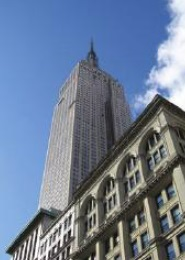

In [10]:
img = Image.open('pic.jpg')
display(img)

Считать в черно-белом виде

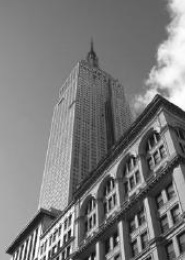

In [11]:
img = Image.open('pic.jpg').convert('L')
display(img)

Считывание множества файлов и сохранение

In [12]:
import os

filelist = ['pic.jpg']
for infile in filelist:
    outfile = os.path.splitext(infile)[0] + '.jpg'
    if infile != outfile:
        try:
            Image.open(infile).save(outfile)
        except IOError:
            print('unable to convert ', infile)

Получить список рисунков

In [13]:
def get_imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

### Создание миниатюр

In [17]:
img = Image.open('pic.jpg')
img.thumbnail((64, 64))

### Обрезка и вставка областей

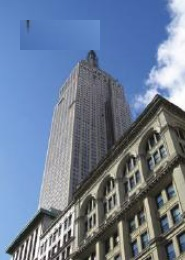

In [18]:
img = Image.open('pic.jpg')
box = (20, 20, 100, 50)
region = img.crop(box)
region = region.transpose(Image.ROTATE_180)
img.paste(region, box)
display(img)

### Изменение размера и поворот

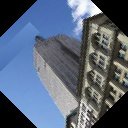

In [20]:
out = img.resize((128, 128))
out = out.rotate(45)
display(out)

## Matplotlib

In [21]:
import matplotlib.pyplot as plt

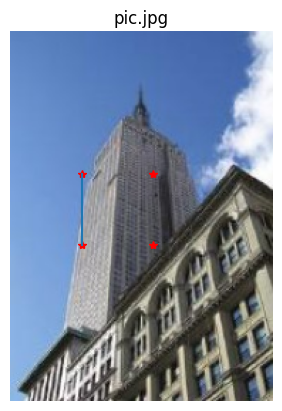

In [23]:
img = Image.open('pic.jpg')
plt.imshow(img)

x = [50, 50, 100, 100]
y = [100, 150, 100, 150]

plt.plot(x, y, 'r*')
plt.plot(x[:2], y[:2])
plt.title('pic.jpg')
plt.axis('off')
plt.show()


### Изолинии и гистограммы

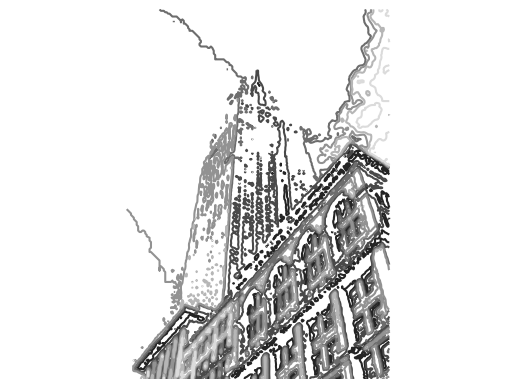

In [24]:
img = np.asarray(Image.open('pic.jpg').convert('L'))
plt.figure()
plt.gray()
plt.contour(img, origin='image')
plt.axis('equal')
plt.axis('off')
plt.show()

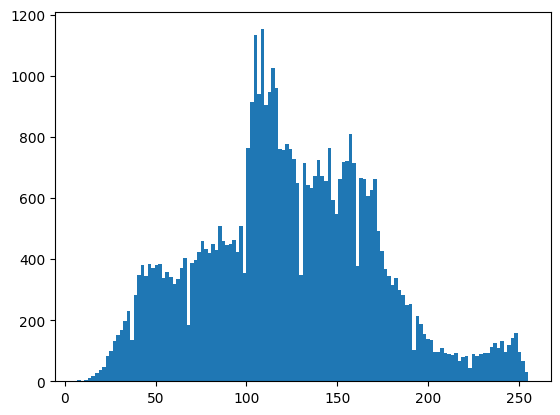

In [25]:
plt.hist(img.flatten(), 128)
plt.show()

### Интерактивное аннотирование

In [ ]:
from matplotlib.pyplot import ginput

img = Image.open('pic.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()
x = ginput(3)
print('Clicked coordinates ', x)

## Numpy

In [29]:
img = np.array(Image.open('pic.jpg'))
print(img.shape, type(img))

img = np.array(Image.open('pic.jpg').convert('L'), dtype='f')
print(img.shape, type(img))

(260, 185, 3) <class 'numpy.ndarray'>
(260, 185) <class 'numpy.ndarray'>


### Преобразование яркости

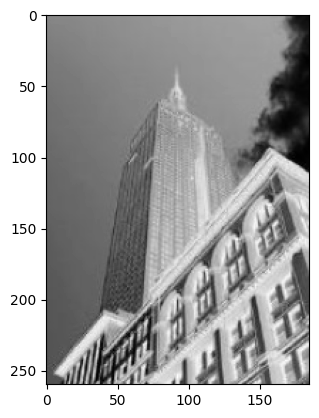

In [30]:
# Инвертирование изображения
img = np.array(Image.open('pic.jpg').convert('L'))
img = 255 - img
plt.imshow(img)

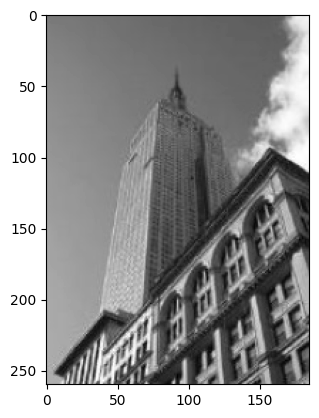

In [31]:
# яркость от 100 до 200
img = np.array(Image.open('pic.jpg').convert('L'))
img = (100.0/255) * img +100
plt.imshow(img)

### PIL from numpy

In [33]:
img = np.array(Image.open('pic.jpg').convert('L'))
img_pil = Image.fromarray(np.uint8(img))

## Выравнивание гистограммы

In [38]:
"""
Выравнивание гистрограммы.

Когда применять: когда все пикселм похожи друг на друга и сложно визуально понять, что находится на изображении.

Функция распределения в таком случае очень неравномерна.
Задача состоит в том, чтобы сделать функцию распределения (cdf) равномерной, превратив ее в линейную.
Функция распределения имеет вид:
cdf(x) = h(0) + h(1) + h(2) + ... + h(x), где 0, 1, 2, .., x - пиксели изображения от 0 до 255.

Формула:
f(x) = round( 255 * (cdf(x) - cdf_min) / (кол-во_пикселей_в_изображений - 1) )
cdf_min - такое значение cdf(x), что cdf(x) != 0
"""


from skimage.io import imread, imsave
import skimage
import itertools
import numpy as np


def load_image(file_path):
    img = imread(file_path)
    return img


def count_pixels_num(img):
    return img.shape[0] * img.shape[1]


def make_histogram(img):
    """Функция принимает целое число 0, ..., 255 и возвращает количество пикселей с яркостью, равной аргументу"""

    h = np.zeros(256, np.uint32) # создаем массив из 256 нулей 
    for value in img.flatten(): # flatten returns a copy of the array collapsed into one dimension.
        h[value] += 1 # строим гистограмму
    return np.array(h)


def make_cdf(h):
    """Строим функцию распределения"""
    # Как работает itertools.accumulate:
    # 2 -> h(0) + h(1) + h(2)
    # 5 -> h(0) + h(1) + h(2) + h(3) + h(4) + h(5)
    # 179 -> h(0) + h(1) + ... + h(179)
    cdf = np.zeros(256, np.uint32) # массив из 256 нулей
    for value in range(256):
        cdf = list(itertools.accumulate(h)) # аккумулируем сумму
    return np.array(cdf)


def compute_cdf_min(cdf):
    """Вычисляем минимальное значение функции распределения (для формулы)"""
    values = sorted(list(set(cdf))) # удалили повторяющиеся значения
    for value in values:
        if values[0] == 0:
            min_cdf = values[1]
        else:
            min_cdf = values[0]
    return min_cdf


def align_histogram(img, min_cdf, pixels_num, output_name):
    """Применяем функцию выравнивания гистограммы"""

    aligned = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pixel = img[x][y]
            aligned[x][y] = round(255 * (cdf[pixel] - min_cdf) / (pixels_num - 1))
    imsave('{}'.format(output_name), aligned)


image = load_image('landscape.png')
pixels_num = count_pixels_num(image)
hist = make_histogram(image)
cdf = make_cdf(hist)
min_cdf = compute_cdf_min(cdf)
aligned_image = align_histogram(image, min_cdf, pixels_num, 'aligned.png')